In [13]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.binance_crawler import *
from talib.abstract import *
from pprint import pprint

In [15]:
def strategy(df, config):
    volume = df.volume
    close = df.close
    
    volume_std = volume.rolling(config["volume_p"]).std()
    volume_mean = volume.rolling(config["volume_p"]).mean()
    
    close_std = close.rolling(config["price_p"]).std()
    close_mean = close.rolling(config["price_p"]).mean()
    
    volume_signal = volume > (volume_mean + volume_std * config["volume_std_coef"])
    price_signal = close > (close_mean + close_std * config["price_std_coef"])
    
    # volume_signal = (volume_signal & (volume_signal.diff() == 1))
    # price_signal = (price_signal & (price_signal.diff() == 1))
        
    df["enter_long"] = volume_signal & price_signal
    df["enter_long"] = df["enter_long"] & (df["enter_long"].diff() == 1)
    df["trade_cost"] = 0.001
    df["bet"] = np.clip(0.01 / df.close.pct_change().rolling(200).std(), 0.1, 2) * 2
    df["stop_loss"] = config["stop_loss"]
    df["take_profit"] = config["take_profit"]
    df["time_cut"] = config["time_cut"]
    return df

In [3]:
def backtest_and_report(config, ticker):
    data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    pprint(calc_from_order_df(order))
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

In [5]:
import ray
from deepcrypto.optimization import *

def metric_fn(order_df, port_df):
    return {"sharpe" : qs.stats.sharpe(port_df["portfolio_value"].resample("1D").last())}

def optimize(df, ticker):
    optimizer = BruteForceOptimizer(
        data=df,
        strategy=strategy,
        config_dict = {
            "time_cut" : [12, 24, 48, 96, 144],
            "stop_loss" : [0.02, 0.03, 0.05, 0.1],
            "take_profit" : [0.05, 0.07, 0.1, 0.15, 0.2],
            'volume_p' : [12, 24, 48, 96],
            'price_p' : [12, 24, 48, 96, 144],
            'volume_std_coef' : [1, 1.5, 2, 2.5, 3, 3.5],
            'price_std_coef' : [1, 1.5, 2, 2.5, 3, 3.5]
        },
        metric_fn=metric_fn,
        result_dir="./results",
        strategy_name=f"VPBreakout_{ticker}",
        n_cores=12
    )
    optimizer.optimize()
    optimizer.save_results()
    return optimizer

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [6]:
ray.init()

2021-05-28 10:28:01,771	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:55856',
 'object_store_address': '/tmp/ray/session_2021-05-28_10-28-00_705455_1296314/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-28_10-28-00_705455_1296314/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-05-28_10-28-00_705455_1296314',
 'metrics_export_port': 60346,
 'node_id': '476a4ce79eaca2645c30527faaab94c154eea7b5962790f1e763b37c'}

In [ ]:
data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", "ETHUSDT")
data = data.backtest.add_defaults()

data = data[:int(data.index.__len__() * 0.7)]

optimizer = optimize(data, "ETHUSDT")
config = optimizer.get_best_result("sharpe")

In [12]:
pprint(config)

{'index': 48150,
 'price_p': 96,
 'price_std_coef': 2,
 'sharpe': 2.3150449062501477,
 'stop_loss': 0.02,
 'take_profit': 0.07,
 'time_cut': 24,
 'volume_p': 24,
 'volume_std_coef': 1}


backtest completed in 0.09722590446472168 seconds
{'bothside_avg_holding_bars': 11.84108527131783,
 'bothside_profit_factor': 2.32933465222766,
 'bothside_total_profit': 7526442.44054065,
 'bothside_total_trades': 258,
 'bothside_win_rate': 46.12403100775194,
 'buyside_avg_holding_bars': 11.84108527131783,
 'buyside_profit_factor': 2.32933465222766,
 'buyside_total_profit': 7526442.44054065,
 'buyside_total_trades': 258,
 'buyside_win_rate': 46.12403100775194,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             24.0%       100.0%

Cumulative Return          61,454.84%  1,085.61%
CAGR%                      465.54%     94.86%

Sharpe                     2.23        0.98
Sortino                    5.47        1.44
Sortino/√2                 3.87        1.02

Max Drawdown               -26.92%     -93.98%
Longest DD Days            117         1101
Volatility (ann.)          61.47%      80.74%
R^2                        0.13        0.13
Calmar                     17.29       1.01
Skew                       3.19        -0.15
Kurtosis                   18.29       4.05

Expected Daily %           0.48%       0.18%
Expected Monthly %         14.98%      5.52%
Expected Yearly %          261.29%     63.98%
Kelly Criterion            26

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-17,2020-05-15,2020-05-30,43,-26.923042,-26.606512
2,2019-01-03,2019-02-13,2019-02-18,46,-23.378361,-18.948221
3,2019-07-09,2019-08-03,2019-10-09,92,-21.468230,-16.762116
4,2019-04-19,2019-05-04,2019-05-11,22,-18.874003,-12.475843
5,2020-09-11,2020-10-01,2020-10-22,41,-18.415802,-15.600057


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


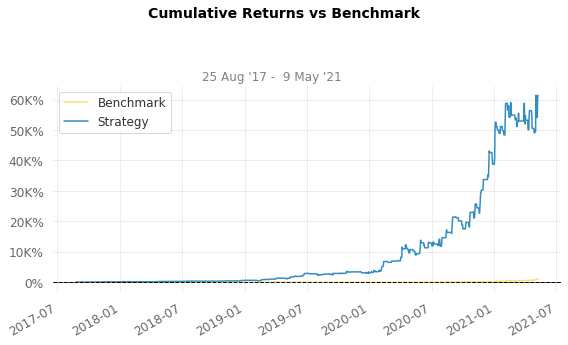

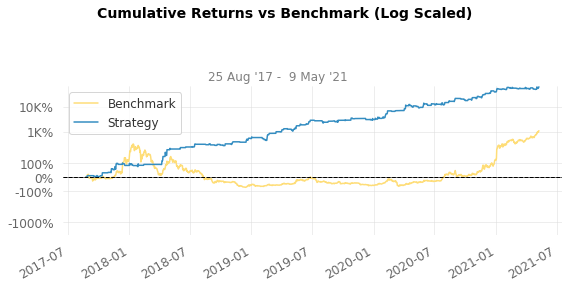

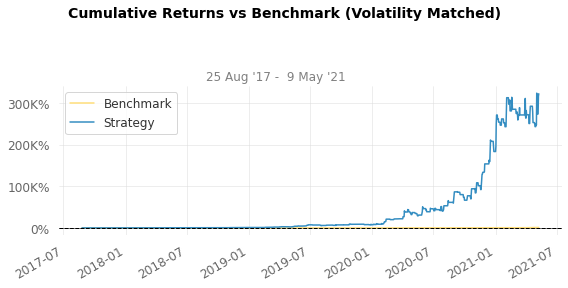

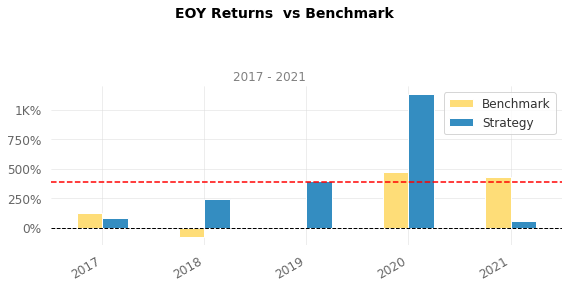

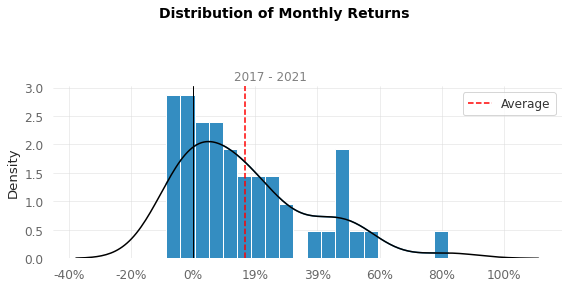

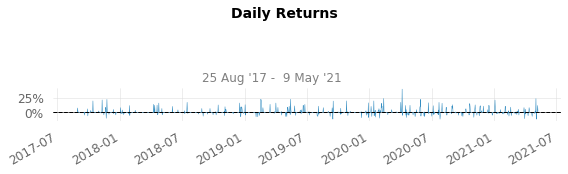

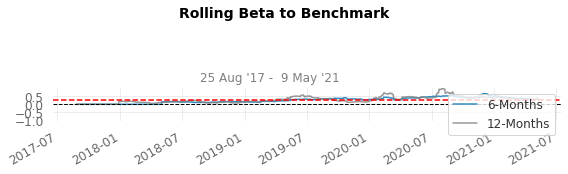

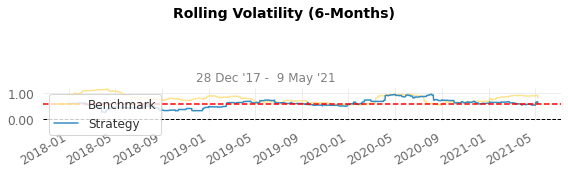

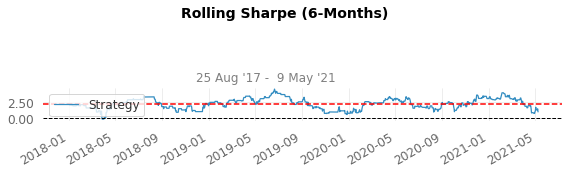

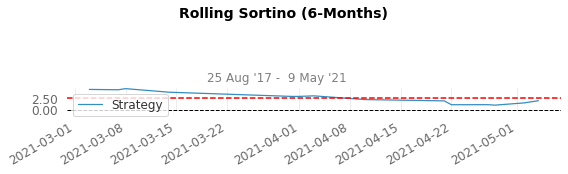

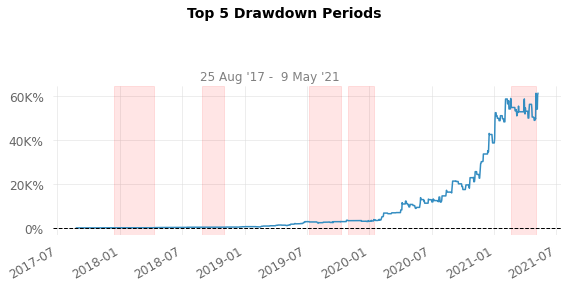

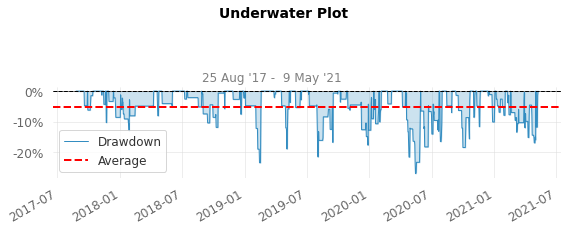

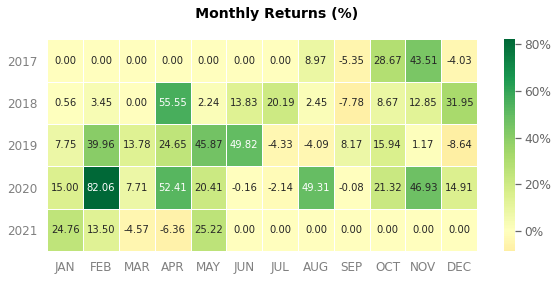

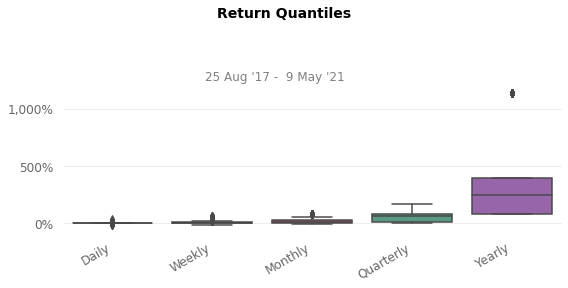

In [11]:
backtest_and_report(config, "ETHUSDT")

In [ ]:
data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", "BTCUSDT")
data = data.backtest.add_defaults()

data = data[:int(data.index.__len__() * 0.7)]

optimizer = optimize(data, "BTCUSDT")
config = optimizer.get_best_result("sharpe")

In [19]:
config = {key : int(val) if val == int(val) else val for key, val in config.items()}
pprint(config)

{'index': 48632,
 'price_p': 96,
 'price_std_coef': 2,
 'sharpe': 2.1833997975733648,
 'stop_loss': 0.03,
 'take_profit': 0.05,
 'time_cut': 24,
 'volume_p': 24,
 'volume_std_coef': 2}


backtest completed in 0.040375471115112305 seconds
{'bothside_avg_holding_bars': 16.111650485436893,
 'bothside_profit_factor': 1.0743329766587493,
 'bothside_total_profit': 1953299.6139180735,
 'bothside_total_trades': 206,
 'bothside_win_rate': 59.70873786407766,
 'buyside_avg_holding_bars': 16.111650485436893,
 'buyside_profit_factor': 1.0743329766587493,
 'buyside_total_profit': 1953299.6139180735,
 'buyside_total_trades': 206,
 'buyside_win_rate': 59.70873786407766,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             22.0%       100.0%

Cumulative Return          12,921.89%  1,267.92%
CAGR%                      271.94%     102.52%

Sharpe                     1.76        1.07
Sortino                    3.9         1.6
Sortino/√2                 2.76        1.13

Max Drawdown               -36.36%     -83.38%
Longest DD Days            135         1079
Volatility (ann.)          61.51%      65.55%
R^2                        0.11        0.11
Calmar                     7.48        1.23
Skew                       4.36        -0.07
Kurtosis                   43.62       4.36

Expected Daily %           0.36%       0.19%
Expected Monthly %         11.17%      5.85%
Expected Yearly %          164.81%     68.74%
Kelly Criterion            22

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-12-25,2021-04-10,2021-05-09,135,-36.364869,-34.691119
2,2020-08-10,2020-10-08,2020-10-21,72,-34.198438,-33.527343
3,2020-10-22,2020-11-04,2020-11-17,26,-34.114091,-27.433292
4,2018-12-24,2019-02-03,2019-02-18,56,-22.674770,-22.399299
5,2019-04-06,2019-04-16,2019-05-03,27,-22.567697,-21.557786


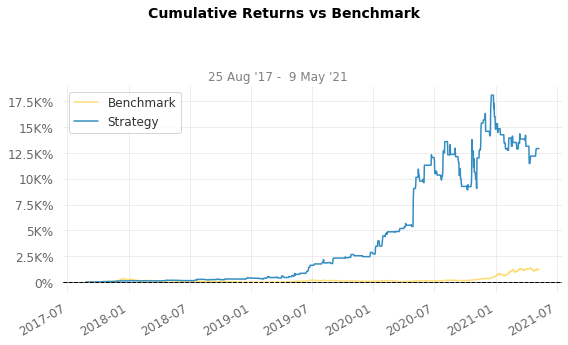

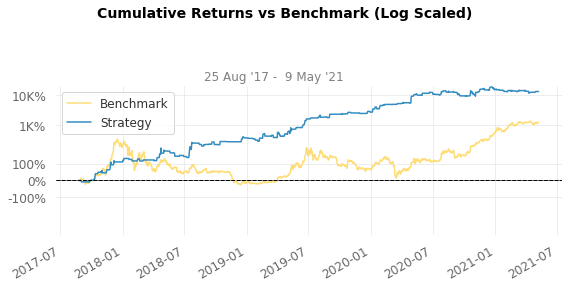

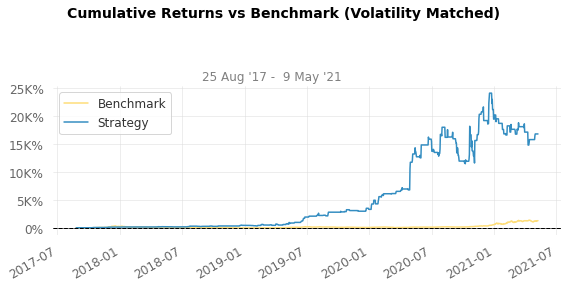

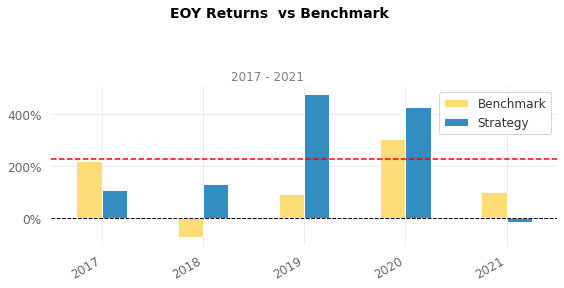

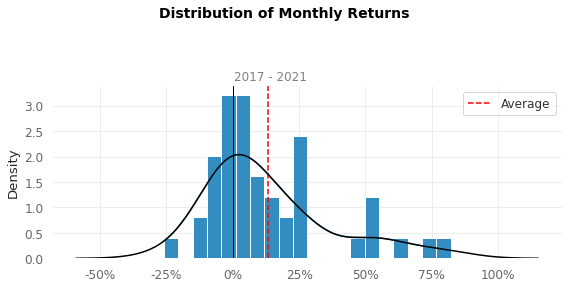

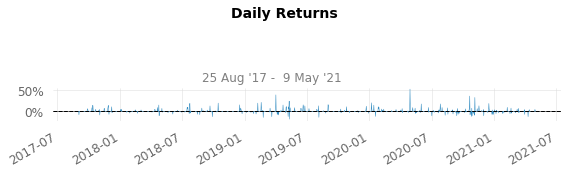

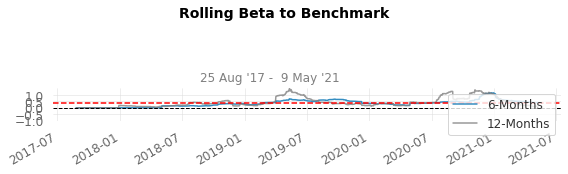

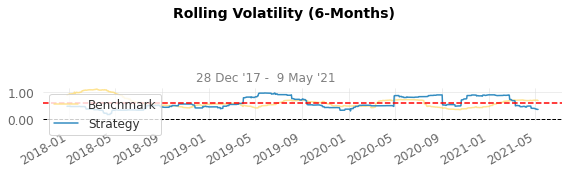

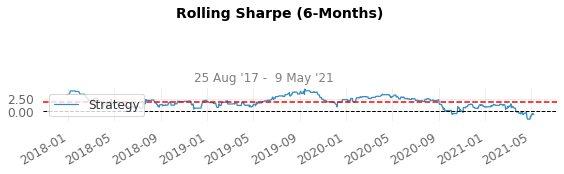

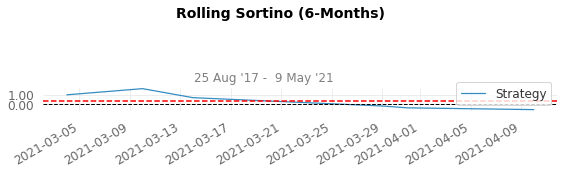

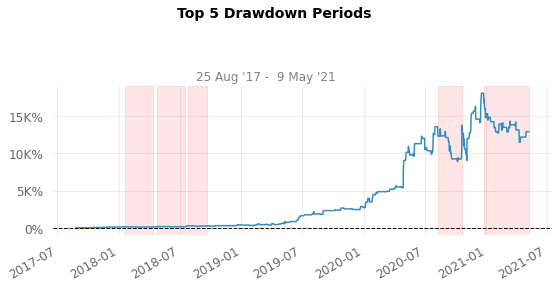

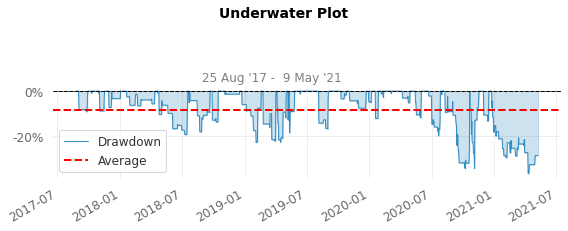

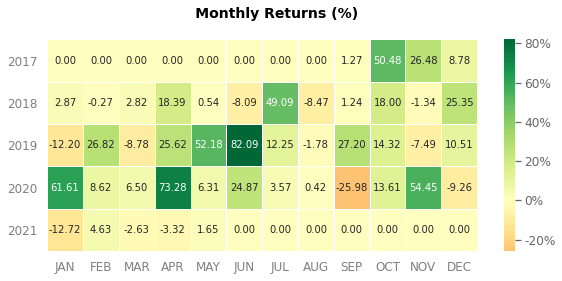

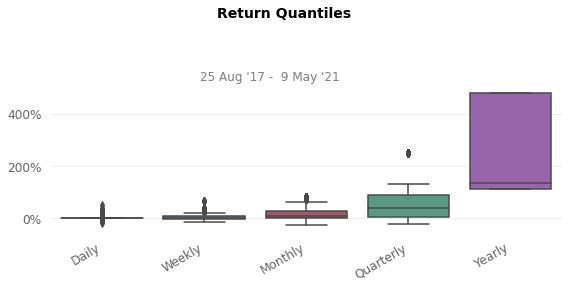

In [20]:
backtest_and_report(config, "BTCUSDT")